In [1]:
import pandas as pd
import numpy as np
import os
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer
import scipy
from sklearn import linear_model, metrics, pipeline, preprocessing
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import time
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

fir the y column: 1 = confirmed fraud, 0 = passed OTP (good customer), -1 = unknown status

# To Do
1. drop duplicates from the dummy variables
2. use new data
3. setup dummy variables as dashboard

In [2]:
os.getcwd()

'C:\\Users\\RJP1F47\\Fraud_Project_loca'

In [3]:
#for reading full df
#df = pd.read_csv('omsa_project_cleaned_data.csv')
df = scipy.sparse.load_npz('omsa_project_cleaned_data.npz').tocsr()
y = pd.read_csv('omsa_project_cleaned_labels.csv')

In [4]:
df.shape

(622571, 122762)

In [5]:
y.value_counts()

Final Review Status
-1                     516080
 0                      91695
 1                      14796
dtype: int64

In [6]:
y = y.values.ravel()
pre_pseudo_labels = y.copy()

In [7]:
pre_ssl_labeled = (y != -1).ravel()

## Modeling Setup
-test model on full dataset, will probably do even better

In [8]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import HuberRegressor
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

# Config Settings

In [9]:
min_change_step = 100
limit_master = 0.95
step_master = 0.05
iterations_max = 200

# Iterative SVM classification

In [10]:
#clf = LinearSVC(dual=False, )
clf = SGDClassifier(warm_start=True, loss='modified_huber', tol=1e-3, max_iter=1000, class_weight='balanced') #warm_start is import for our setup


In [11]:
#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
auc = []
auc_orig = []
accuracy_orig_data = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    auc.append(roc_auc_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    auc_orig.append(roc_auc_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
isvm_y = y.copy()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_isvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
auc.append(roc_auc_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
auc_orig.append(roc_auc_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

142
--- 839.6939685344696 seconds ---


#start timer
start_time = time.time()

iterations = 1
limit = 0.95
step = 0.05
y = pre_pseudo_labels.copy()

accuracy = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < 100 and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel()
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < 500:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_isvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
print("--- %s seconds ---" % (time.time() - start_time))

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

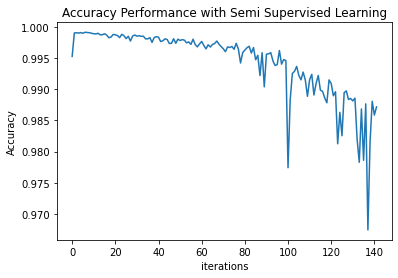

In [12]:
plt.plot(range(0,iterations), accuracy)
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [13]:
missing_labels_imputed = abs(remain_unlabeled_obs - remain_unlabeled_obs[0])

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

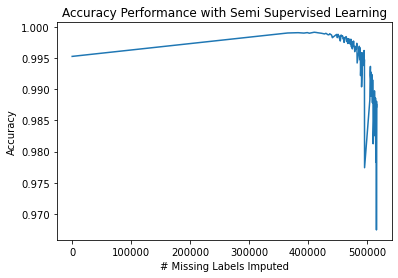

In [14]:
plt.plot(missing_labels_imputed, accuracy)
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [15]:
missing_labels_imputed

array([     0, 365428, 383035, 392994, 398677, 402202, 410326, 413635,
       416354, 423061, 425903, 427975, 430191, 433944, 435426, 436713,
       439863, 441195, 442612, 448251, 448699, 449139, 449541, 450703,
       451999, 453427, 453937, 454612, 455658, 456056, 457087, 457861,
       458622, 458901, 459177, 460232, 460510, 461030, 462614, 464654,
       464957, 465227, 465958, 466300, 466998, 467220, 467659, 468391,
       468491, 469616, 469955, 470437, 470617, 471021, 471569, 471849,
       472567, 472933, 473540, 474311, 474426, 474628, 475045, 475358,
       475734, 476704, 476964, 477114, 477324, 478480, 478839, 479124,
       479492, 479579, 480375, 481896, 482588, 482905, 483211, 485871,
       486393, 486624, 486854, 487214, 487716, 487931, 488682, 488989,
       490489, 490737, 492469, 492824, 493410, 493987, 494275, 494691,
       494978, 495226, 495496, 495564, 495791, 504733, 505300, 505415,
       505700, 505761, 506390, 506659, 506909, 507103, 507765, 507924,
      

In [16]:
pd.DataFrame(pre_pseudo_labels).value_counts()

-1    516080
 0     91695
 1     14796
dtype: int64

In [17]:
pd.DataFrame(y).value_counts()

0    453317
1    169254
dtype: int64

In [18]:
#save values
accuracy_isvm = accuracy.copy()
iterations_isvm = iterations
missing_labels_imputed_isvm = missing_labels_imputed.copy()
y_isvm = y.copy()
accuracy_orig_data_isvm = accuracy_orig_data.copy()
auc_isvm = auc.copy()
auc_orig_isvm = auc_orig.copy()

# Cluster-then-label (fuzzy c-means & svm approach)
1. visualize clusters with TSNE
2. fuzzy c-means clusters
3. analysis of cluster separability
4. Assign labels
5. SVM and look at accuracy

In [185]:
#conda install fuzzy-c-means

In [186]:
import skfuzzy as fuzz
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

#### Optimizing and utilizing PCA before KMeans

In [187]:
from sklearn.decomposition import TruncatedSVD

In [188]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [189]:
tsvd = TruncatedSVD()
tsvd.fit(df)
optimal_comp = select_n_components(tsvd.explained_variance_ratio_, 0.999999)
print(optimal_comp)

2


In [190]:
#tsvd = TruncatedSVD(n_components = optimal_comp)
tsvd = TruncatedSVD(n_components = 100)
df_pca = tsvd.fit_transform(df)

In [191]:
df_pca.shape

(622571, 100)

We are going to use a sample to determine the optimal K value here for KMeans

In [192]:
sample = np.random.choice(list(range(0,df.shape[0])), 2000)

In [193]:
from sklearn.cluster import KMeans #https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(points.shape[0]):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [194]:
 optimal_k = np.argmin(calculate_WSS(df_pca[sample], 10)) +1 #plus 1 for index starts at 1 as min cluster size

In [195]:
print(optimal_k)

3


Run our clustering now

In [196]:
#kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans = KMeans(n_clusters=optimal_k, random_state=0)

In [197]:
#array of the
df_cluster = kmeans.fit_transform(df_pca)
df_cluster_assignments = kmeans.fit_predict(df_pca)

In [198]:
df_cluster.shape

(622571, 3)

In [199]:
#for this model we are changing the X we use. 
df_orig = df.copy()
df = df_cluster.copy()

use our new clustering df to run svm classifier

In [200]:
#resetup since we are using warm_start
clf = SGDClassifier(warm_start=True, loss='modified_huber', tol=1e-3, max_iter=1000, class_weight='balanced') #warm_start is import for our setup

In [201]:
#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
auc = []
auc_orig = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    auc.append(roc_auc_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    auc_orig.append(roc_auc_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
csvm_y = y.copy()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
auc.append(roc_auc_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
auc_orig.append(roc_auc_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

25
--- 82.9164776802063 seconds ---


In [202]:
#return to normal
df = df_orig.copy()

In [203]:
len(list(range(0,iterations)))

25

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

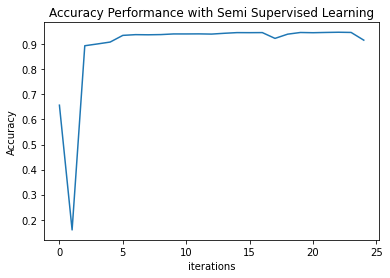

In [204]:
plt.plot(range(0,iterations), accuracy)
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [205]:
missing_labels_imputed = abs(remain_unlabeled_obs - remain_unlabeled_obs[0])

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

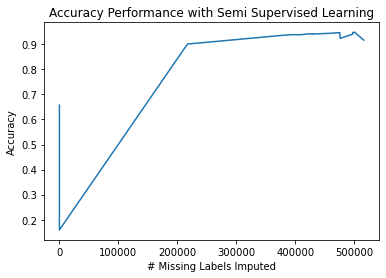

In [206]:
plt.plot(missing_labels_imputed, accuracy)
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [207]:
missing_labels_imputed

array([     0,      0, 215114, 217664, 254206, 377231, 394871, 405204,
       411119, 420459, 423192, 429001, 429001, 459326, 474385, 475154,
       475155, 476230, 497242, 497270, 497299, 497871, 500907, 500907,
       516080])

In [208]:
pd.DataFrame(pre_pseudo_labels).value_counts()

-1    516080
 0     91695
 1     14796
dtype: int64

In [209]:
pd.DataFrame(y).value_counts()

0    348283
1    274288
dtype: int64

In [210]:
#save values
accuracy_csvm = accuracy.copy()
iterations_csvm = iterations
missing_labels_imputed_csvm = missing_labels_imputed.copy()
y_csvm = y.copy()
accuracy_orig_data_csvm = accuracy_orig_data.copy()
auc_csvm = auc.copy()
auc_orig_csvm = auc_orig.copy()

# ROUND 2: Cluster-then-label (fuzzy c-means & svm approach)
1. visualize clusters with TSNE
2. fuzzy c-means clusters
3. analysis of cluster separability
4. Assign labels
5. SVM and look at accuracy

In [211]:
#conda install fuzzy-c-means

In [212]:
import skfuzzy as fuzz
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

#### Optimizing and utilizing PCA before KMeans

In [213]:
from sklearn.decomposition import TruncatedSVD

In [214]:
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

In [215]:
tsvd = TruncatedSVD()
tsvd.fit(df)
optimal_comp = select_n_components(tsvd.explained_variance_ratio_, 0.999999)
print(optimal_comp)

2


In [216]:
#tsvd = TruncatedSVD(n_components = optimal_comp)
tsvd = TruncatedSVD(n_components = 100)
df_pca = tsvd.fit_transform(df)

In [217]:
df_pca.shape

(622571, 100)

We are going to use a sample to determine the optimal K value here for KMeans

In [218]:
sample = np.random.choice(list(range(0,df.shape[0])), 2000)

In [219]:
from sklearn.cluster import KMeans #https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

# function returns WSS score for k values from 1 to kmax
def calculate_WSS(points, kmax):
  sse = []
  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)
    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)
    curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(points.shape[0]):
      curr_center = centroids[pred_clusters[i]]
      curr_sse += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_sse)
  return sse

In [220]:
 optimal_k = np.argmin(calculate_WSS(df_pca[sample], 10)) +1 #plus 1 for index starts at 1 as min cluster size

In [221]:
print(optimal_k)

10


Run our clustering now

In [222]:
#kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans = KMeans(n_clusters=10, random_state=0)

In [223]:
#array of the
df_cluster = kmeans.fit_transform(df_pca)
df_cluster_assignments = kmeans.fit_predict(df_pca)

In [224]:
df_cluster.shape

(622571, 10)

In [225]:
#for this model we are changing the X we use. 
df_orig = df.copy()
df = df_cluster.copy()

use our new clustering df to run svm classifier

In [226]:
#resetup since we are using warm_start
clf = SGDClassifier(warm_start=True, loss='modified_huber', tol=1e-3, max_iter=1000, class_weight='balanced') #warm_start is import for our setup

In [227]:
#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
auc = []
auc_orig = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    auc.append(roc_auc_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    auc_orig.append(roc_auc_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
csvm_y = y.copy()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
auc.append(roc_auc_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
auc_orig.append(roc_auc_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

18
--- 104.14280772209167 seconds ---


In [228]:
#return to normal
df = df_orig.copy()

In [229]:
len(list(range(0,iterations)))

18

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

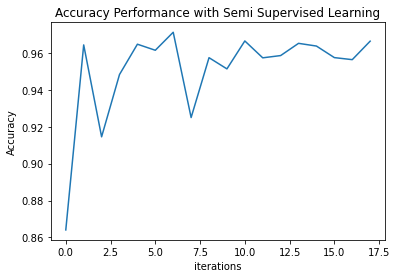

In [230]:
plt.plot(range(0,iterations), accuracy)
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [231]:
missing_labels_imputed = abs(remain_unlabeled_obs - remain_unlabeled_obs[0])

Text(0.5, 1.0, 'Accuracy Performance with Semi Supervised Learning')

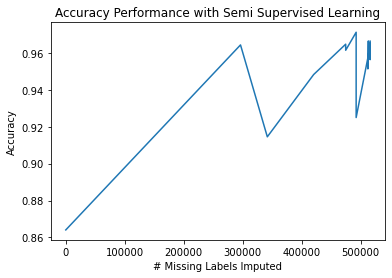

In [232]:
plt.plot(missing_labels_imputed, accuracy)
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

In [233]:
missing_labels_imputed

array([     0, 296236, 341714, 420308, 474573, 474602, 492334, 492334,
       512238, 512238, 513014, 513162, 513275, 515464, 515464, 515840,
       516077, 516080])

In [234]:
pd.DataFrame(pre_pseudo_labels).value_counts()

-1    516080
 0     91695
 1     14796
dtype: int64

In [235]:
pd.DataFrame(y).value_counts()

1    360703
0    261868
dtype: int64

In [236]:
#save values
accuracy_csvm2 = accuracy.copy()
iterations_csvm2 = iterations
missing_labels_imputed_csvm2 = missing_labels_imputed.copy()
y_csvm2 = y.copy()
accuracy_orig_data_csvm2 = accuracy_orig_data.copy()
auc_csvm2 = auc.copy()
auc_orig_csvm2 = auc_orig.copy()
probs_csvm2 = probs_csvm

# KNN Label Propagation (Previously TSVM) 

In [237]:
#ONLY IF WE HAVE TIME!!!

In [238]:
#can't accept a sparse X matrix
#from sklearn.semi_supervised import LabelPropagation
#clf = LabelPropagation(kernel = 'knn')

In [239]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neural_network import MLPClassifier
#NN =  MLPClassifier(random_state=1, warm_start=True)
#clf = SelfTrainingClassifier(NN)
#clf = MLPClassifier(random_state=1, warm_start=True)
#clf=MLPClassifier(random_state=1,warm_start=True, hidden_layer_sizes = (50,), max_iter=50, n_iter_no_change=3)

In [240]:
#reset y
#y = pre_pseudo_labels.copy()
#run model, -1 labels are considered "unlabeled"
#clf.fit(df, y)

#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

#start timer
start_time = time.time()

iterations = 1
limit = limit_master
step = step_master
y = pre_pseudo_labels.copy()

accuracy = []
accuracy_orig_data = []
remain_unlabeled_obs = [(y == -1).sum()]
converged = False
while iterations < iterations_max and (not converged):
    y0 = y.copy()
    
    #restart the filters based on what we have labeled now
    pseudo_assigned = (y != -1).ravel() #update to reflect newly assigned labels that don't require a label assignment now
    pseudo_missing = np.invert(pseudo_assigned)
    #restart the split
    x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
   
    #fit on most recent training data
    clf.fit(x_train, y_train)
    probs = clf.predict_proba(df)
    
    #save accuracy
    y_test_preds = clf.predict(x_test)
    accuracy.append(accuracy_score(y_test, y_test_preds))
    
    #accuracy on just the original labeled points
    accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))
    
    
    #filter for if an element met the min probability in any column
    min_prob_met = probs > limit
    
    #filter out rows where the min probability is not met on any obs for either class
    any_strong_prediction = min_prob_met.sum(axis=1) != 0
    
    #will give us which class had the highest probability (combined with any_strong_prediction will get us where we want to be)
    highest_prob_class = np.argmax(probs, axis=1)
    
    #save predictions of missing label data points and where we had a strong enough prediction for either class
    y[pseudo_missing & any_strong_prediction] = highest_prob_class[pseudo_missing & any_strong_prediction]
    
    
    #how are we doing now with accuracy and these new labels
    #y_test_preds = clf.predict(x_test)
    #accuracy.append(accuracy_score(y_test, y_test_preds))
    remain_unlabeled_obs.append((y == -1).sum())
    
    if np.array_equal(y0,y):
        limit = limit - step
    if (remain_unlabeled_obs[-2] - remain_unlabeled_obs[-1]) < min_change_step:
        limit = limit - step
    if remain_unlabeled_obs[-1] == 0:
        converged = True
        
    #print((y == -1).sum()) #obs still to update after this iteration
    #print(limit)
    iterations +=1
print(iterations)    
#final accuracy
pseudo_assigned = (y != -1).ravel()
pseudo_missing = np.invert(pseudo_assigned)
x_train, x_test, y_train, y_test = train_test_split(df[pseudo_assigned], y[pseudo_assigned], test_size=0.15, random_state=30, stratify=y[pseudo_assigned])
clf.fit(x_train, y_train)
probs_csvm = clf.predict_proba(df)
y_test_preds = clf.predict(x_test)
accuracy.append(accuracy_score(y_test, y_test_preds))
accuracy_orig_data.append(accuracy_score(y[pre_ssl_labeled], clf.predict(df)[pre_ssl_labeled]))

#end timer
print("--- %s seconds ---" % (time.time() - start_time))

plt.plot(range(0,iterations), accuracy)
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

missing_labels_imputed = abs(remain_unlabeled_obs - remain_unlabeled_obs[0])

plt.plot(missing_labels_imputed, accuracy)
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance with Semi Supervised Learning')

missing_labels_imputed

pd.DataFrame(pre_pseudo_labels).value_counts()

pd.DataFrame(y).value_counts()

#save values
accuracy_lp = accuracy.copy()
iterations_lp = iterations
missing_labels_imputed_lp = missing_labels_imputed.copy()
y_lp = y.copy()
accuracy_orig_data_lp = accuracy_orig_data.copy()

### Self Training Classifier True Version

In [241]:
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.neural_network import MLPClassifier
#NN =  MLPClassifier(random_state=1, warm_start=True)
NN = clf = SGDClassifier(warm_start=True, loss='modified_huber', tol=1e-3, max_iter=1000, class_weight='balanced') #warm_start is import for our setup
clf = SelfTrainingClassifier(NN)
y = pre_pseudo_labels.copy()
clf.fit(df, y)
y_stc = clf.predict(df)
accuracy_stc = (accuracy_score(y[pre_ssl_labeled], y_stc[pre_ssl_labeled]))
iteration_labeled = clf.labeled_iter_


In [242]:
print(accuracy_stc)

0.9951826914950559


In [243]:
probs_stc = clf.predict_proba(df)

# Analysis

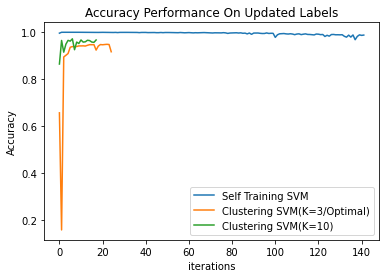

In [244]:
plt.plot(range(0,iterations_isvm), accuracy_isvm, label = 'Self Training SVM')
plt.plot(range(0,iterations_csvm), accuracy_csvm, label = 'Clustering SVM(K=3/Optimal)')
plt.plot(range(0,iterations_csvm2), accuracy_csvm2, label = 'Clustering SVM(K=10)')
#plt.plot(range(0,iterations_lp), accuracy_lp, label = 'KNN Label Propagation')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Updated Labels')
plt.legend()
plt.show()

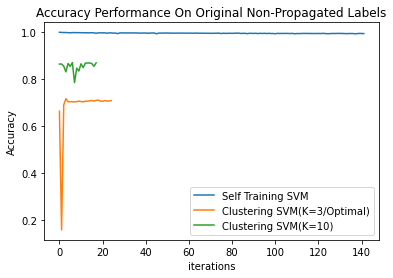

In [245]:
plt.plot(range(0,iterations_isvm), accuracy_orig_data_isvm, label = 'Self Training SVM')
plt.plot(range(0,iterations_csvm), accuracy_orig_data_csvm, label = 'Clustering SVM(K=3/Optimal)')
plt.plot(range(0,iterations_csvm2), accuracy_orig_data_csvm2, label = 'Clustering SVM(K=10)')
#plt.plot(range(0,iterations_lp), accuracy_orig_data_lp, label = 'KNN Label Propagation')
plt.xlabel('iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Original Non-Propagated Labels')
plt.legend()
plt.show()

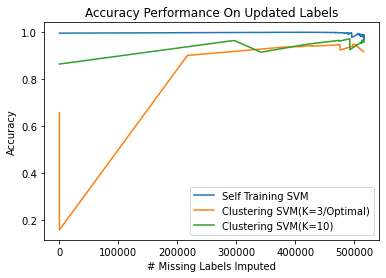

In [246]:
plt.plot(missing_labels_imputed_isvm, accuracy_isvm, label = 'Self Training SVM')
plt.plot(missing_labels_imputed_csvm, accuracy_csvm, label = 'Clustering SVM(K=3/Optimal)')
plt.plot(missing_labels_imputed_csvm2, accuracy_csvm2, label = 'Clustering SVM(K=10)')
#plt.plot(missing_labels_imputed_lp, accuracy_lp, label = 'KNN Label Propagation')
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Updated Labels')
plt.legend()
plt.show()

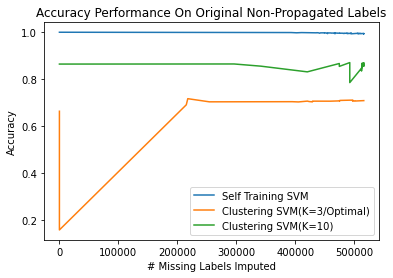

In [247]:
plt.plot(missing_labels_imputed_isvm, accuracy_orig_data_isvm, label = 'Self Training SVM')
plt.plot(missing_labels_imputed_csvm, accuracy_orig_data_csvm, label = 'Clustering SVM(K=3/Optimal)')
plt.plot(missing_labels_imputed_csvm2, accuracy_orig_data_csvm2, label = 'Clustering SVM(K=10)')
#plt.plot(missing_labels_imputed_lp, accuracy_orig_data_lp, label = 'KNN Label Propagation')
plt.xlabel('# Missing Labels Imputed')
plt.ylabel('Accuracy')
plt.title('Accuracy Performance On Original Non-Propagated Labels')
plt.legend()
plt.show()

In [248]:
#Absolute Difference in predicted probability across the different models
abs_diff_probabilities_models = np.zeros((4,4))
for ii, i in enumerate([probs_isvm, probs_csvm, probs_stc]):
    for ji, j in enumerate([probs_isvm, probs_csvm, probs_csvm2, probs_stc]):
        abs_diff_probabilities_models[ii,ji] = abs(i - j).sum()

print(abs_diff_probabilities_models)

[[     0.         559279.10662259 559279.10662259 136227.11312894]
 [559279.10662259      0.              0.         529468.22783066]
 [136227.11312894 529468.22783066 529468.22783066      0.        ]
 [     0.              0.              0.              0.        ]]


In [249]:
#Sum of Squared Difference in Probabilities across classes
ssd_classes_and_models = np.zeros((4,1))
for ii, i in enumerate([probs_isvm, probs_csvm, probs_csvm2, probs_stc]):
        ssd_classes_and_models[ii] = ((i[:,0] - i[:,1])**2).sum()

print(ssd_classes_and_models)

[[585288.62237987]
 [549934.0199639 ]
 [549934.0199639 ]
 [564969.85849515]]


In [250]:
#Mean Probability of classes
median_probability_classes = np.zeros((4,2))
for ii, i in enumerate([probs_isvm, probs_csvm, probs_csvm2, probs_stc]):
        median_probability_classes[ii,0] = np.median(i[:,0])
        median_probability_classes[ii,1] = np.median(i[:,1])

print(median_probability_classes)

[[1.         0.        ]
 [0.13096069 0.86903931]
 [0.13096069 0.86903931]
 [1.         0.        ]]


In [251]:
master_list_isvm = []
master_list.append(missing_labels_imputed_isvm)
master_list.append(range(0,iterations_isvm))
master_list.append(accuracy_isvm)
master_list.append(accuracy_orig_data_isvm)
master_list.append(auc_isvm)
master_list.append(auc_orig_isvm)
master_list.append(missing_labels_imputed_isvm)
master_list.append(missing_labels_imputed_isvm)


NameError: name 'master_list' is not defined

In [252]:
y = pre_pseudo_labels.copy()

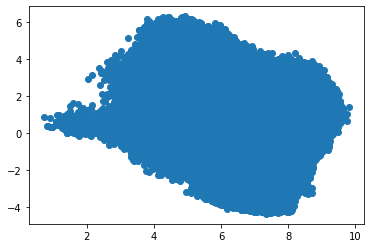

In [278]:
plt.scatter(df_pca[:,0], df_pca[:,1])
idx = np.random.randint(df_pca.shape[0], size=5000)


In [279]:
unlabeled = (y[idx]==-1).ravel()
positive_fraud = (y[idx]==1).ravel()
negative_fraud = (y[idx]==0).ravel()

master_idx = [unlabeled, positive_fraud, negative_fraud]

In [280]:
idx1

array([False, False, False, ..., False, False, False])

In [281]:
df_cluster_assignments

array([6, 7, 7, ..., 2, 2, 2])

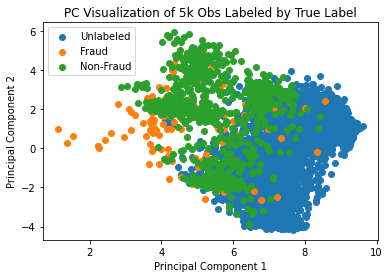

In [284]:

plt.scatter(df_pca[idx,0][unlabeled], df_pca[idx,1][unlabeled], label='Unlabeled')
plt.scatter(df_pca[idx,0][positive_fraud], df_pca[idx,1][positive_fraud], label='Fraud')
plt.scatter(df_pca[idx,0][negative_fraud], df_pca[idx,1][negative_fraud], label='Non-Fraud')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PC Visualization of 5k Obs Labeled by True Label')
plt.legend()

plt.scatter(df_pca[idx,0], df_pca[idx,1], c=y[idx], label=y[idx])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PC Visualization of 20k Obs Labeled by True Label')
plt.legend()

Text(0.5, 1.0, 'PC Visualization of 5k Obs Labeled by KMeans Clustering Results')

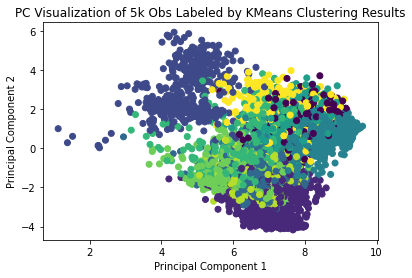

In [285]:
plt.scatter(df_pca[idx,0], df_pca[idx,1], c=df_cluster_assignments[idx], label=df_cluster_assignments[idx])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PC Visualization of 5k Obs Labeled by KMeans Clustering Results')
#.legend()

In [286]:
pd.DataFrame(y_isvm).value_counts()

0    453317
1    169254
dtype: int64

In [287]:
pd.DataFrame(y_csvm).value_counts()

0    348283
1    274288
dtype: int64

In [288]:
pd.DataFrame(y_csvm2).value_counts()

1    360703
0    261868
dtype: int64

In [290]:
unlabeled = (y_isvm[idx]==-1).ravel()
positive_fraud = (y_isvm[idx]==1).ravel()
negative_fraud = (y_isvm[idx]==0).ravel()

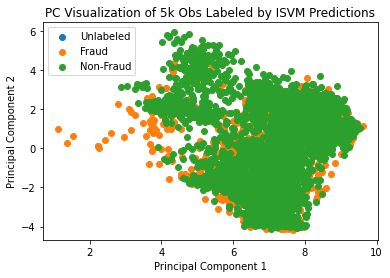

In [291]:
plt.scatter(df_pca[idx,0][unlabeled], df_pca[idx,1][unlabeled], label='Unlabeled')
plt.scatter(df_pca[idx,0][positive_fraud], df_pca[idx,1][positive_fraud], label='Fraud')
plt.scatter(df_pca[idx,0][negative_fraud], df_pca[idx,1][negative_fraud], label='Non-Fraud')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PC Visualization of 5k Obs Labeled by ISVM Predictions')
plt.legend()